# Loading the data

1.   Checking missing values
2.   Making it ready for further analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization styles
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif')
plt.style.use('ggplot')

# Load the dataset with explicit date parsing
df = pd.read_csv('SMARTPHONE RETAIL OUTLET SALE DATA.csv', encoding='ascii', parse_dates=['Date'], dayfirst=True)

# Clean column names
df.columns = (df.columns.str.lower()
              .str.replace(" ", "_")
              .str.replace("/", "_")
              .str.replace(".", "_")
              .str.replace("f_y", "fiscal_year"))

# Ensure numeric columns are properly typed
numeric_cols = ['quantity', 'price', 'amount']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for null values
print("\nNull Values Before Cleaning:")
print(df.isnull().sum())

# Drop rows with null values in 'p_no' (if any)
df.dropna(subset=['p_no'], inplace=True)

# Verify no remaining null values
print("\nNull Values After Cleaning:")
print(df.isnull().sum())

# Reset index for further analysis if needed
df.reset_index(inplace=True)


Null Values Before Cleaning:
date                        0
fiscal_year                 0
quarter                     0
p_no                        1
payment_type                0
type_of_product             0
quantity                    0
price                       0
amount                      0
type_of_accessory_mobile    0
dtype: int64

Null Values After Cleaning:
date                        0
fiscal_year                 0
quarter                     0
p_no                        0
payment_type                0
type_of_product             0
quantity                    0
price                       0
amount                      0
type_of_accessory_mobile    0
dtype: int64


# Analysis


1.   Decomposition
2.   ADF Test
3.   acf AND pacf plot
4.   Deseasonalization



/tmp/ipython-input-2852726102.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['amount'].resample('M').sum()


<Figure size 1200x800 with 0 Axes>

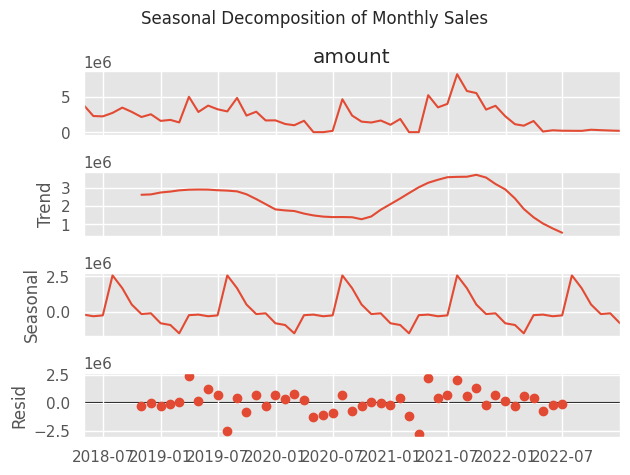

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure 'date' is the index and 'amount' is numeric
df.set_index('date', inplace=True)
monthly_sales = df['amount'].resample('M').sum()

# Perform seasonal decomposition (assuming yearly seasonality, period=12 for monthly data)
decomposition = seasonal_decompose(monthly_sales, model='additive', period=12)

# Plot decomposition
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Monthly Sales')
plt.tight_layout()
plt.show()

# Reset index for further analysis
df.reset_index(inplace=True)

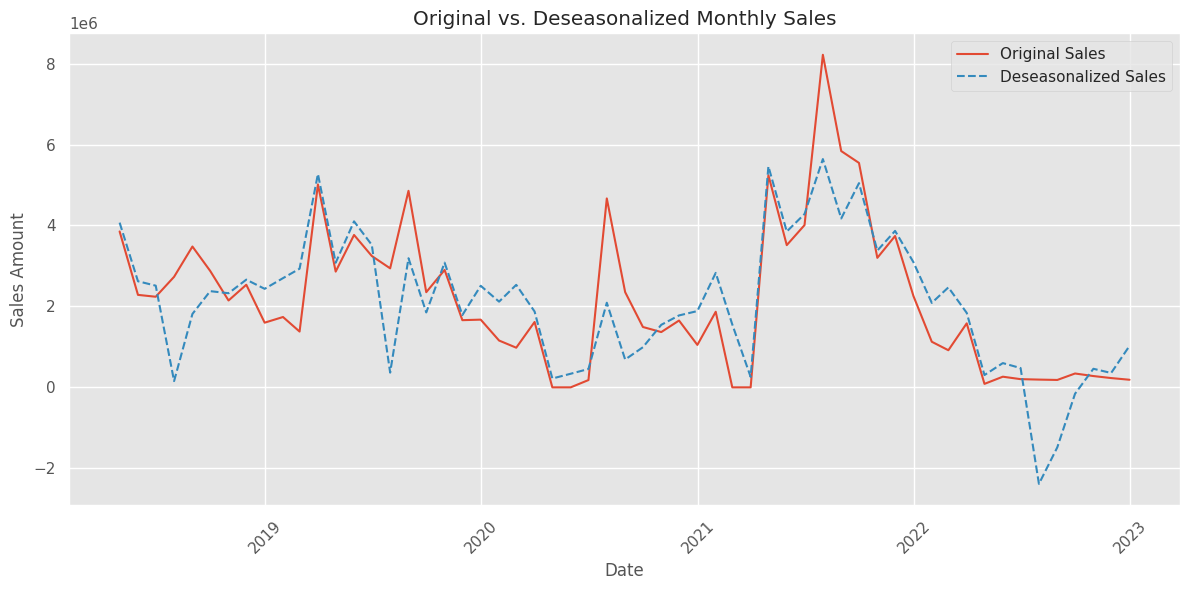

In [3]:
# Deseasonalize the series
deseasonalized = monthly_sales - decomposition.seasonal

# Plot original vs. deseasonalized
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Original Sales')
plt.plot(deseasonalized, label='Deseasonalized Sales', linestyle='--')
plt.title('Original vs. Deseasonalized Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1248989871.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['amount'].resample('M').sum()


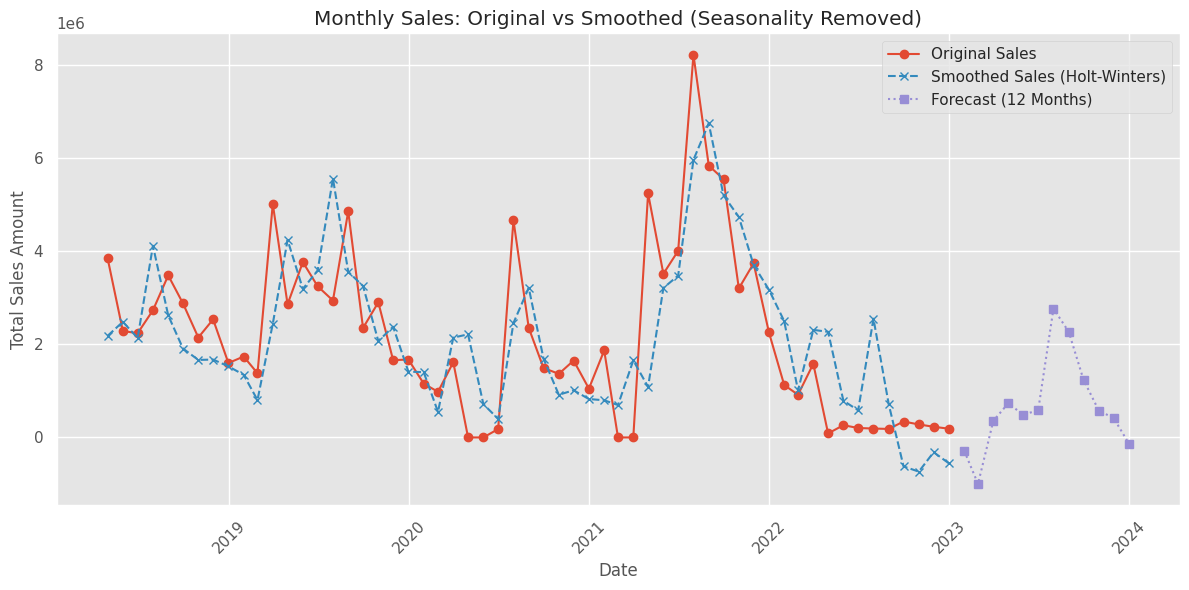

ADF Test Results for Smoothed Sales:
ADF Statistic: -2.4800288144347897
p-value: 0.12040945240731193
Critical Values:
   1%: -3.552928203580539
   5%: -2.9147306250000002
   10%: -2.595137155612245

Smoothed Data Head:
                 date  original_sales  smoothed_sales
date                                                 
2018-04-30 2018-04-30      3851349.91    2.181015e+06
2018-05-31 2018-05-31      2284744.70    2.482532e+06
2018-06-30 2018-06-30      2238484.60    2.135195e+06
2018-07-31 2018-07-31      2730875.95    4.115642e+06
2018-08-31 2018-08-31      3479150.55    2.619644e+06


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

# Assuming df is already loaded and 'date' is set as index with monthly sales calculated
# If not, ensure the following from your code:
df.set_index('date', inplace=True)
monthly_sales = df['amount'].resample('M').sum()

# Apply Holt-Winters Exponential Smoothing
# Seasonal period = 12 for monthly data with yearly seasonality
model = ExponentialSmoothing(
    monthly_sales,
    seasonal='add',
    seasonal_periods=12,
    trend='add',
    damped_trend=True
).fit()

# Get the smoothed (fitted) values
smoothed_sales = model.fittedvalues

# Forecast future values (optional, for visualization)
forecast_steps = 12  # Forecast 12 months ahead
forecast = model.forecast(steps=forecast_steps)

# Plot original vs smoothed data
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales, label='Original Sales', marker='o')
plt.plot(smoothed_sales.index, smoothed_sales, label='Smoothed Sales (Holt-Winters)', linestyle='--', marker='x')
plt.plot(forecast.index, forecast, label='Forecast (12 Months)', linestyle=':', marker='s')
plt.title('Monthly Sales: Original vs Smoothed (Seasonality Removed)')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optionally, store the smoothed data for further analysis
smoothed_df = pd.DataFrame({
    'date': monthly_sales.index,
    'original_sales': monthly_sales,
    'smoothed_sales': smoothed_sales
})

# Perform ADF test on the smoothed sales data
adf_result = adfuller(smoothed_sales.dropna())
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# Print ADF test results
print("ADF Test Results for Smoothed Sales:")
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Reset index for further use
df.reset_index(inplace=True)

# Display the first few rows of smoothed data
print("\nSmoothed Data Head:")
print(smoothed_df.head())

In [5]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(monthly_sales.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] < 0.05:
    print("Series is likely stationary (no need to difference)")
else:
    print("Series is likely non-stationary (consider differencing or seasonal adjustment)")

ADF Statistic: -2.4453777507532193
p-value: 0.12933617428838484
Critical Values: {'1%': np.float64(-3.5552728880540942), '5%': np.float64(-2.9157312396694217), '10%': np.float64(-2.5956695041322315)}
Series is likely non-stationary (consider differencing or seasonal adjustment)


# 1st order differencing
# 2nd order differencing


In [6]:
# Step 3: Apply First Differencing
diff = deseasonalized.diff().dropna()
print("\nApplied first differencing.")

# ADF Test on First Differenced Series
print("\nADF Test on First Differenced Series:")
result_diff = adfuller(diff)
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])
print('Critical Values:', result_diff[4])
if result_diff[1] < 0.05:
    print("Series is likely stationary.")
else:
    print("Series is still non-stationary. Applying second differencing.")


Applied first differencing.

ADF Test on First Differenced Series:
ADF Statistic: -11.544644789214358
p-value: 3.565473074646694e-21
Critical Values: {'1%': np.float64(-3.5552728880540942), '5%': np.float64(-2.9157312396694217), '10%': np.float64(-2.5956695041322315)}
Series is likely stationary.



ADF Test on Second-Differenced Series:
ADF Statistic: -5.56342412608071
p-value: 1.5235683877302308e-06
Critical Values:
   1%: -3.5714715250448363
   5%: -2.922629480573571
   10%: -2.5993358475635153
Second-differenced series is likely stationary.


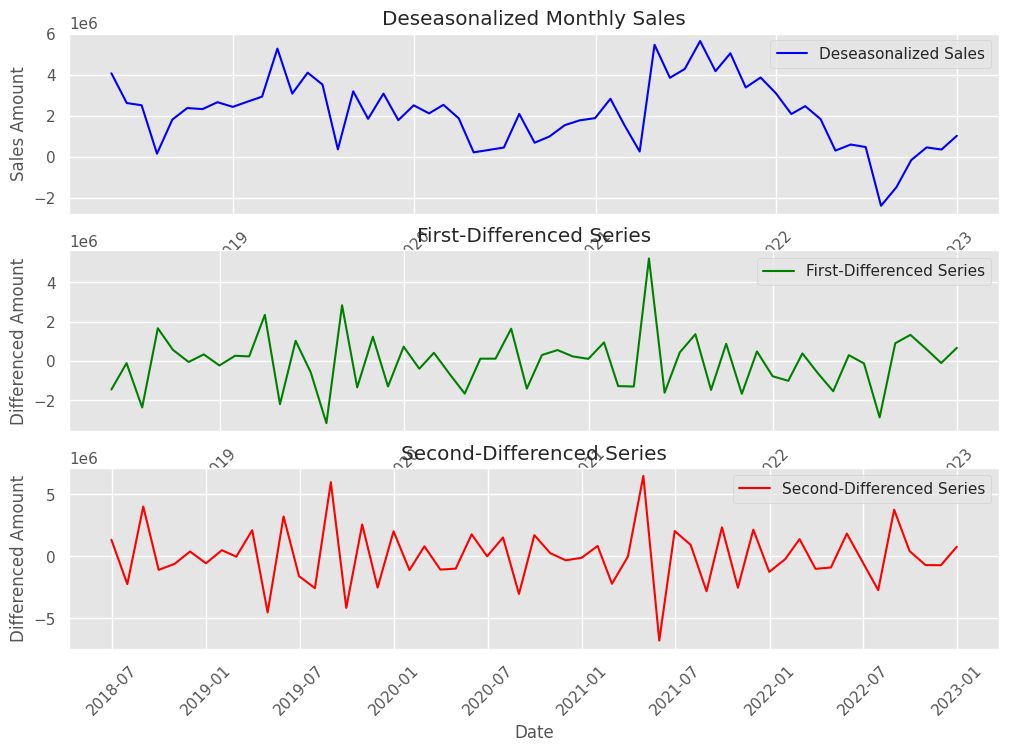

In [7]:
# Apply second-order differencing
diff2 = diff.diff().dropna()

# Perform ADF test on second-differenced series
result_diff2 = adfuller(diff2)
adf_statistic = result_diff2[0]
p_value = result_diff2[1]
critical_values = result_diff2[4]

# Print ADF test results
print("\nADF Test on Second-Differenced Series:")
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')
if p_value < 0.05:
    print("Second-differenced series is likely stationary.")
else:
    print("Second-differenced series is still non-stationary. Further analysis may be needed.")

# Plot original deseasonalized, first-differenced, and second-differenced series
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(deseasonalized.index, deseasonalized, label='Deseasonalized Sales', color='blue')
plt.title('Deseasonalized Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(diff.index, diff, label='First-Differenced Series', color='green')
plt.title('First-Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Amount')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(diff2.index, diff2, label='Second-Differenced Series', color='red')
plt.title('Second-Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Amount')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Reset index for further use
df.reset_index(inplace=True)

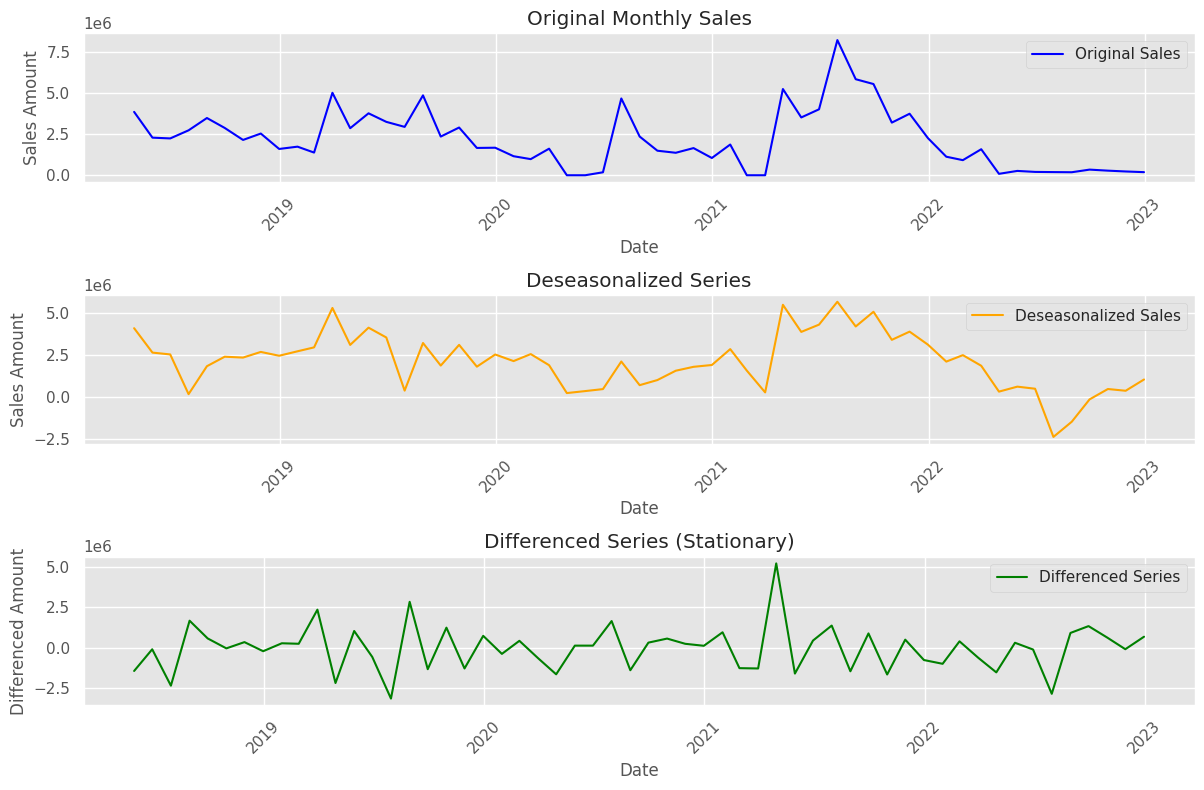

In [8]:
# Step 5: Plot Original, Deseasonalized, and Differenced Series
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(monthly_sales, label='Original Sales', color='blue')
plt.title('Original Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(deseasonalized, label='Deseasonalized Sales', color='orange')
plt.title('Deseasonalized Series')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(diff, label='Differenced Series', color='green')
plt.title('Differenced Series (Stationary)')
plt.xlabel('Date')
plt.ylabel('Differenced Amount')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

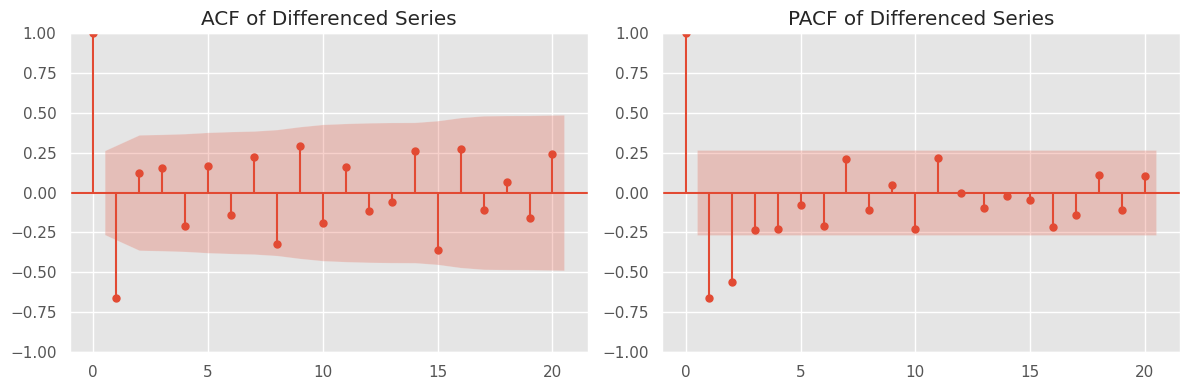

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Added imports
# Step 4: Plot ACF and PACF for ARIMA Parameter Selection
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_acf(diff2, lags=20, ax=plt.gca())
plt.title('ACF of Differenced Series')
plt.subplot(122)
plot_pacf(diff2, lags=20, ax=plt.gca())
plt.title('PACF of Differenced Series')
plt.tight_layout()
plt.show()

##Just for the Practice, Results can be wrong because dataset is manipulated.*